[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/03.regression_contd-and-classification/a.polynomial-regression.ipynb)

Predict `BufferHealth` (seconds ahead in the buffer) only based on network measurements.

**Why?**: The operator may decide to allocate more bandwidth to users whose buffer is suffering.

In [1]:
import pandas as pd # For dataframes (tables)
import matplotlib.pyplot as plt # For plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np # For arange
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold


# Load the functions I prepared for you
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/feature_engineering.py

import feature_engineering                                 
from andrea_models import AndreaLinearRegression

--2022-04-22 10:59:11--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py.1’

andrea_models.py.1  100%[===================>]   3.12K  --.-KB/s    in 0s      

2022-04-22 10:59:11 (48.3 MB/s) - ‘andrea_models.py.1’ saved [3190/3190]

--2022-04-22 10:59:11--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/feature_engineering.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
dataset_to_use = 'B1'
mydatasets_folder = "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/"

filename = "df."+ dataset_to_use+"_2.csv"
complete_name = mydatasets_folder+filename
!wget $complete_name

--2022-04-22 10:59:12--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/df.B1_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58556 (57K) [text/plain]
Saving to: ‘df.B1_2.csv.1’

df.B1_2.csv.1       100%[===================>]  57.18K  --.-KB/s    in 0.003s  

2022-04-22 10:59:12 (17.0 MB/s) - ‘df.B1_2.csv.1’ saved [58556/58556]



In [3]:
df = pd.read_csv(filename)

# Univariate Polynomial Regression

Let's check what are the most correlated features to `BufferHealth`.

In [4]:
feats = feature_engineering.get_features_correlated_to_target(
        df, target_feature='BufferHealth'
        )
feats

BufferHealth          1.00
BufferProgress_log    0.97
BufferProgress        0.97
PacketsReceived       0.61
KBytesReceived        0.61
                      ... 
Buffering              NaN
Paused                 NaN
Playing                NaN
CollectData            NaN
BufferValid            NaN
Name: BufferHealth, Length: 147, dtype: float64

We can not use `BufferProgress`, as it is not a network-layer measure and the net operator would not have access to the buffer of users.

`BytesReceived` is also highly correlated (to have more seconds-ahead, we need to download more).

[Text(0, 0.5, 'BufferHealth'), Text(0.5, 0, 'BytesReceived')]

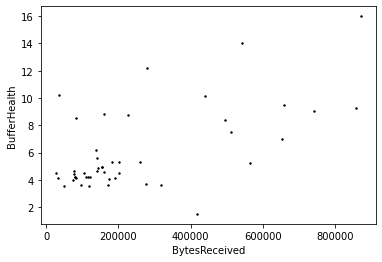

In [5]:
feature = 'BytesReceived'
fig, ax = plt.subplots() # This creates just a canvas
ax.scatter(df[feature],df['BufferHealth'],color='black',
           s=2, label='all samples') # ax is the actual figure
ax.set (xlabel=feature, ylabel='BufferHealth')

Values are squashed on the left, let's use the log-transformed feature to see the dependency better.

[Text(0, 0.5, 'BufferHealth'), Text(0.5, 0, 'BytesReceived_log')]

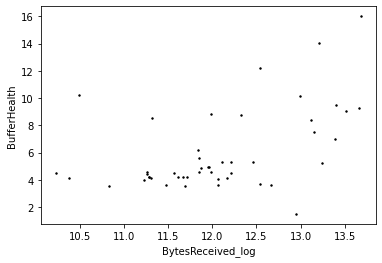

In [6]:
feature = 'BytesReceived_log'
fig, ax = plt.subplots() # This creates just a canvas
ax.scatter(df[feature],df['BufferHealth'],color='black',
           s=2, label='all samples') # ax is the actual figure
ax.set (xlabel=feature, ylabel='BufferHealth')

The dependency is clearer now, although, in terms of Pearson's correlation coefficient 
$$
\rho(\texttt{BytesReceived},\texttt{BufferHealth}) \ge 
\rho(\texttt{BytesReceived_log},\texttt{BufferHealth})
$$ 

Don't be surprised: Pearson's correlation only captures linear dependency and we see that here the dependency is not linear

In [7]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=2)

Let's put in evidence the test samples

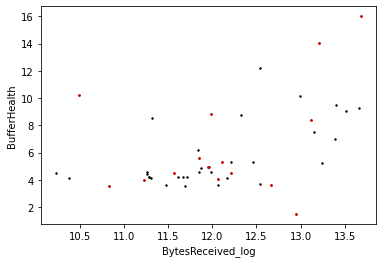

In [8]:
ax.scatter(df_test[feature],df_test['BufferHealth'],color='red',
           s=2, label='test') # ax is the actual figure
fig

OLS linear regression

In [9]:
feature = 'BytesReceived_log'
target = 'BufferHealth'
X_train = df_train[feature].values.reshape(-1,1)
X_test = df_test[feature].values.reshape(-1,1)
y_train = df_train[target].values
y_test = df_test[target].values

model = AndreaLinearRegression(feature)
model.fit(X_train, y_train)
model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     17.51
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           0.000229
Time:                        10:59:13   Log-Likelihood:                -64.395
No. Observations:                  32   AIC:                             132.8
Df Residuals:                      30   BIC:                             135.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.7603      4.677     -2.942      0.0

The model is significant (p-values are low). Let's test it.

In [10]:
y_pred = model.predict(X_test)
RMSE_linear = sqrt(mean_squared_error(y_pred, y_test))
print('The test error is of ',RMSE_linear,' seconds')

The test error is of  3.7228082304941905  seconds


Let's plot the regression line

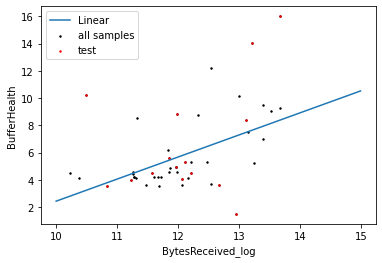

In [11]:
interval = np.arange(10, 15, 0.01).reshape(-1,1)
h_values = model.predict(interval)
ax.plot(interval,h_values, label="Linear ")
ax.legend()
fig

Not great. We would like to have a curve more flexible than a rigid straight line.

To run a quadratic regression, we first need to add to the column `BytesReceived_log` the column $\texttt{BytesReceived_log}^2$.

In [12]:
X_train_poly = PolynomialFeatures(degree=2, 
                include_bias=False).fit_transform(X_train)
X_train_poly

array([[ 10.37402229, 107.62033849],
       [ 12.16272141, 147.93179218],
       [ 11.68839023, 136.61846627],
       [ 11.25940002, 126.77408887],
       [ 12.32598674, 151.92994917],
       [ 11.8706069 , 140.91130823],
       [ 12.99278303, 168.81241077],
       [ 13.66424804, 186.71167441],
       [ 11.28062764, 127.25255997],
       [ 11.32280558, 128.2059262 ],
       [ 10.23426503, 104.74018077],
       [ 11.25712958, 126.72296641],
       [ 12.53561377, 157.14161271],
       [ 11.47326946, 131.63591203],
       [ 13.39753148, 179.49384964],
       [ 11.71440402, 137.22726145],
       [ 11.98382245, 143.61200039],
       [ 11.28156071, 127.2736121 ],
       [ 13.24652779, 175.4704984 ],
       [ 13.14613264, 172.82080331],
       [ 11.31062567, 127.93025294],
       [ 12.54261274, 157.31713427],
       [ 13.39098953, 179.31860069],
       [ 13.51802997, 182.73713426],
       [ 12.21554762, 149.21960356],
       [ 12.466088  , 155.40335001],
       [ 11.61205561, 134.83983554],
 

In [13]:
model = AndreaLinearRegression()
model.fit(X_train_poly, y_train)
model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     10.23
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           0.000435
Time:                        10:59:13   Log-Likelihood:                -63.209
No. Observations:                  32   AIC:                             132.4
Df Residuals:                      29   BIC:                             136.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.2576     52.452      1.225      0.2

Let's plot the line

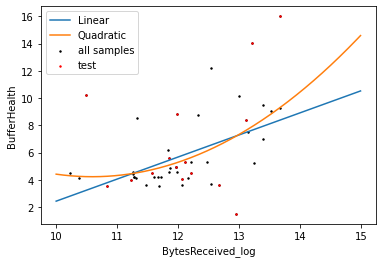

In [14]:
interval = interval.reshape(-1,1)
interval_poly = PolynomialFeatures(degree=2, 
                include_bias=False).fit_transform(interval)
h_values = model.predict(interval_poly)

ax.plot(interval,h_values, label="Quadratic")
ax.legend()
fig

In [15]:
X_test_poly = PolynomialFeatures(degree=2, 
                include_bias=False).fit_transform(X_test)
# include_bias=False, since the bias term will be added
# by AndreaLinearRegression

y_train_pred = model.predict(X_train_poly)
RMSE_train_quadr = sqrt(mean_squared_error(y_train_pred, y_train))

y_pred = model.predict(X_test_poly)
RMSE_quadr = sqrt(mean_squared_error(y_pred, y_test))
print('The test error is ',RMSE_quadr,
          ' seconds; with linear regression it was', RMSE_linear)

The test error is  3.434935939419482  seconds; with linear regression it was 3.7228082304941905


Let's try with cubic regression

train RMSE:  1.736097166801989  seconds; With quadratic regression it was  1.744308287934826
test RMSE:  3.5062243994982722  seconds; With quadratic regression it was  3.434935939419482


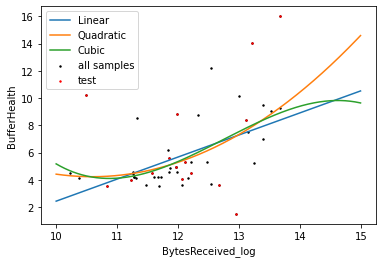

In [16]:
#@title Default title text
mydegree = 3
X_train_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(X_train)
model = AndreaLinearRegression()
model.fit(X_train_poly, y_train)

X_test_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(
                        X_test)
                
y_train_pred = model.predict(X_train_poly)
RMSE_train_cub = sqrt(mean_squared_error(y_train_pred, y_train))

y_pred = model.predict(X_test_poly)
RMSE_cub = sqrt(mean_squared_error(y_pred, y_test))
print("train RMSE: ", RMSE_train_cub, " seconds; With quadratic regression it was ",
             RMSE_train_quadr)
print("test RMSE: ", RMSE_cub, " seconds; With quadratic regression it was ",
             RMSE_quadr)

### plot
interval_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(interval)
h_values = model.predict(interval_poly)

ax.plot(interval,h_values, label="Cubic")
ax.legend()
fig

Let's increase a lot the degree of the polynomial

RMSE:  3.750735399310576


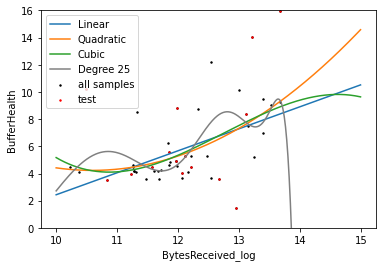

In [17]:
mydegree = 25
X_train_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(X_train)
model = AndreaLinearRegression()
model.fit(X_train_poly, y_train)

X_test_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(
                        X_test)
y_pred = model.predict(X_test_poly)
RMSE_now = sqrt(mean_squared_error(y_pred, y_test))
print("RMSE: ", RMSE_now)

### plot
interval_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(interval)
h_values = model.predict(interval_poly)


ax.plot(interval,h_values, label="Degree "+str(mydegree), color="gray" )
ax.legend()
ax.set_ylim([0, 16] )
fig

This is a typical example of overfit.

The model is so flexible that it can adapt **too** well to training data. 



**Generalization** means instead to "step back" from the observed data and not adapting too much

# Pipelines

We have repeated so far a lot of ugly code:

In [18]:
X_train_poly = PolynomialFeatures(degree=3, 
                include_bias=False).fit_transform(X_train)
model = AndreaLinearRegression()
model.fit(X_train_poly, y_train)

X_test_poly = PolynomialFeatures(degree=3, 
                include_bias=False).fit_transform(X_test)
y_pred = model.predict(X_test_poly)

We can write things in a more compact way, using pipelines

In [19]:
def MyPolynomialRegression(degree=2):
    return make_pipeline(PolynomialFeatures(degree, include_bias=False), 
                         AndreaLinearRegression())


Now `my_poly_regression` is an object which has a `fit` and a `predict` function.

You can now use MyPolynomialRegression(..) as follows.

In [20]:
model = MyPolynomialRegression(degree=3)
model.fit(X_train, y_train) # Equivalent to lines 1-3
y_pred = model.predict(X_test) # Equivalent to lines 6-8

In [21]:
sqrt(mean_squared_error(y_test,y_pred))

3.5062243994982722

## How does a pipeline works

We have seen that using pipeline makes our code more elegant, more compact and more understandable. Let's see more in detail some general rules when using pipelines. More details can be found [in this page](https://scikit-learn.org/stable/modules/compose.html).

* The first arguments of `make_pipeline` must be "transformers", i.e., they must have a `fit_transform(..)` method, like the `PolynomialFeatures` in our case. In our case we used just one transformer, but we can also use a chain of transformers.
* The last argument of `make_pipeline` must be a "model", i.e., it must have functions `fit(..)` and `predict(..)`, like `AndreaLinearRegression` in our case.
* When you call `fit(some_df)` on a pipeline obtained via `make_pipeline(transformer1, transformer2, mymodel)`, the following things happen, in sequence:
    * `transformed_data1 = transformer1.fit_transform(some_df)`
    * `transformed_data2 = transformer2.fit_transform(transformed_data1)`
    * `mymodel.fit(transformed_data2)`
* When you then call `predict(some_other_df)` on the pipeline, the following things happen in parallel:
    * `transformed_other_data1 = transformer1.transform(some_df)`
    * `transformed_other_data2 = transformer2.transform(transformed_other_data1)`
    * `mymodel.predict(transformed_other_data2)`


# Grid search

So far we have tried different polynomial degree and see how their performance look like.

We now perform a systematic search of the best one. To this aim, we train different regressions, each with a different degree, and evaluate each of them via cross-validation.
At the end, we take the degree that gave us the smallest error.

In [22]:
parameters_to_test = {'polynomialfeatures__degree': np.arange(1,30)}
k_fold = KFold(n_splits=5, shuffle=True, random_state=6)

grid = GridSearchCV( MyPolynomialRegression(), parameters_to_test,
                   cv = k_fold, scoring='neg_mean_squared_error')
grid.get_params()

{'cv': KFold(n_splits=5, random_state=6, shuffle=True),
 'error_score': nan,
 'estimator': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                 ('andrealinearregression', AndreaLinearRegression())]),
 'estimator__andrealinearregression': AndreaLinearRegression(),
 'estimator__andrealinearregression__fit_intercept': True,
 'estimator__memory': None,
 'estimator__polynomialfeatures': PolynomialFeatures(include_bias=False),
 'estimator__polynomialfeatures__degree': 2,
 'estimator__polynomialfeatures__include_bias': False,
 'estimator__polynomialfeatures__interaction_only': False,
 'estimator__polynomialfeatures__order': 'C',
 'estimator__steps': [('polynomialfeatures',
   PolynomialFeatures(include_bias=False)),
  ('andrealinearregression', AndreaLinearRegression())],
 'estimator__verbose': False,
 'n_jobs': None,
 'param_grid': {'polynomialfeatures__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18,

In [23]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=6, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False)),
                                       ('andrealinearregression',
                                        AndreaLinearRegression())]),
             param_grid={'polynomialfeatures__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             scoring='neg_mean_squared_error')

In the following we see:
* For each split, the test error per each degree
* For each degree, the score averaged among all the splits
* For each degree, which position it is in the rank of the best ones

In [24]:
grid.cv_results_

{'mean_fit_time': array([0.00188398, 0.00170951, 0.0013341 , 0.00101933, 0.00100079,
        0.00101099, 0.00100098, 0.00125475, 0.00142527, 0.00105171,
        0.00113349, 0.00126228, 0.00127735, 0.00109811, 0.00120845,
        0.00110626, 0.00116577, 0.00111828, 0.00111785, 0.00124292,
        0.00260901, 0.00191298, 0.00121427, 0.00187578, 0.00217695,
        0.00135303, 0.00123491, 0.00153923, 0.00168076]),
 'mean_score_time': array([0.00083642, 0.00090775, 0.00070615, 0.00055366, 0.00051455,
        0.00063725, 0.00051446, 0.00066772, 0.00079694, 0.00055766,
        0.00060749, 0.0007319 , 0.00062833, 0.00060778, 0.00069261,
        0.00059533, 0.00058985, 0.00058045, 0.00059652, 0.00060129,
        0.00085802, 0.00073509, 0.00070176, 0.00104418, 0.00093637,
        0.00064301, 0.00064158, 0.00073581, 0.00090261]),
 'mean_test_score': array([  -3.91198371,   -3.58565749,   -3.87316569,   -4.51408534,
          -4.76095337,   -4.08789623,   -4.17474135,   -4.42947409,
          -4.

The following degree is the one with the highest score

In [25]:
grid.best_params_

{'polynomialfeatures__degree': 2}

Taking the regression with this degree, the cross validation score is:

In [26]:
grid.best_score_

-3.58565748622163

The cross-validation root mean square error (RMSE):

In [27]:
sqrt(-grid.best_score_)

1.8935832398449322

The regression model is:

In [28]:
model = grid.best_estimator_

We can evaluate it in the test set.

In [29]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sqrt(mean_squared_error(y_pred, y_test) )

3.434935939419482